In [55]:
import torch
import numpy as np
from lerf.encoders.openclip_encoder import OpenCLIPNetworkConfig, OpenCLIPNetwork
from torch.nn.functional import cosine_similarity

positive_threshold = 0.6
contrastive_temperature = 1.0

image_encoder = OpenCLIPNetwork(OpenCLIPNetworkConfig())

def contrastive_loss(mask, features, support_feature):
    """
    Referring to CLIP https://arxiv.org/pdf/2103.00020.pdf
    Args:
        mask: [N, 1]
        features: [N, K]
        support_feature: [1, K]
    """
    labels = (mask > positive_threshold).to(torch.float32)
    
    similarity = features @ support_feature.T * torch.exp(torch.tensor(contrastive_temperature))
    contrastive_loss = torch.nn.functional.binary_cross_entropy_with_logits(similarity[..., 0], labels)
    
    return contrastive_loss

def similar_func(feature_q, support):
    phrases_embeds = torch.cat([support, image_encoder.neg_embeds], dim=0)
    p = phrases_embeds.to(feature_q.dtype)  # phrases x 512
    output = torch.mm(feature_q, p.T)  # rays x phrases
    positive_vals = output[..., :1]  # rays x 1
    negative_vals = output[..., 1:]  # rays x N_phrase
    repeated_pos = positive_vals.repeat(1, len(image_encoder.negatives))  # rays x N_phrase

    sims = torch.stack((repeated_pos, negative_vals), dim=-1)  # rays x N-phrase x 2
    softmax = torch.softmax(10 * sims, dim=-1)  # rays x n-phrase x 2
    best_id = softmax[..., 0].argmin(dim=1)  # rays x 2
    score = torch.gather(softmax, 1, best_id[..., None, None].expand(best_id.shape[0], len(image_encoder.negatives), 2))[
        :, 0, :
    ]
    return score[..., 0]

def self_support(feature_q, support):
    """
    Args:
        feature:[N, K]
        support:[1, K]
    """

    # pred_1 = F.cosine_similarity(feature_q, support, dim=1) # 
    # print_shape(pred_1)
    # pred_1 = similar_func(feature_q, support)
    pred_1 = cosine_similarity(feature_q, support, dim=1)

    fg_thres = 0.9 #0.9 #0.6
    bg_thres = 0.4 #0.6
    cur_feat = feature_q
    f_h, f_w = feature_q.shape

    print(f'pred_1 min: {pred_1.min()}, max: {pred_1.max()}')
    print(f'pred_1 > fg_thres: {(pred_1 > fg_thres).sum()}')
    print(f'1 - pred_1 > bg_thres: {((1 - pred_1) > bg_thres).sum()}')
    
    if (pred_1 > fg_thres).sum() > 0:
        fg_feat = cur_feat[(pred_1>fg_thres)] # [N_f, K]
    else:
        fg_feat = cur_feat[torch.topk(pred_1, 12).indices] 
    if ((1 - pred_1) > bg_thres).sum() > 0:
        bg_feat = cur_feat[((1 - pred_1)>bg_thres)] # [N_b, K]
    else:
        bg_feat = cur_feat[torch.topk((1 - pred_1), 12).indices] 
            # global proto
            
            
    fg_proto = fg_feat.mean(0)
    bg_proto = bg_feat.mean(-1)

    # local proto
    # fg_feat_norm = fg_feat / torch.norm(fg_feat, 2, 0, True) # 1024, N1
    # bg_feat_norm = bg_feat / torch.norm(bg_feat, 2, 0, True) # 1024, N2
    # cur_feat_norm = cur_feat / torch.norm(cur_feat, 2, 0, True) # 1024, N3

    # fg_feat_t = fg_feat.t() 
    # bg_feat_t = bg_feat.t() 
    
    # fg_sim = torch.matmul(cur_feat, fg_feat_t) * 2.0 # N, N_f
    # bg_sim = torch.matmul(cur_feat, bg_feat_t) * 2.0 # N, N_b

    # fg_sim = fg_sim.softmax(-1)
    # bg_sim = bg_sim.softmax(-1)

    # fg_proto_local = torch.matmul(fg_sim, fg_feat) # N, K
    # bg_proto_local = torch.matmul(bg_sim, bg_feat) # N, K

    # SSFP_1, SSBP_1, ASFP_1, ASBP_1 = self_support_loss(img_ray_1, support_ray)
    self_support = support * 0.5 + fg_proto * 0.5
    
    # self_support_mask = F.cosine_similarity(feature_q, self_support)
    # self_support_mask = similar_func(feature_q, self_support)
    self_support_mask = cosine_similarity(feature_q, self_support, dim=1)

                
    return self_support_mask

In [29]:
import imageio

featuremap = np.load('/disk1/yichen/lerf/clip_featuremap_1.npy')
print(featuremap.shape)

rgb = imageio.imread('/disk1/yichen/lerf/clip_featuremap_1.png')
print(rgb.shape)

(354, 512, 512)
(354, 512, 3)


/tmp/ipykernel_12757/2247611216.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb = imageio.imread('/disk1/yichen/lerf/clip_featuremap_1.png')


torch.Size([181248, 2])
torch.Size([354, 512, 1])


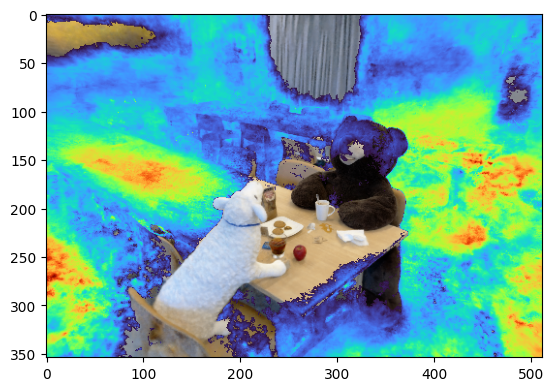

In [85]:
from nerfstudio.utils.colormaps import ColormapOptions, apply_colormap
import matplotlib.pyplot as plt

positives = ['floor']

image_encoder.set_positives(positives)

feature_flatten = featuremap.reshape(-1, 512)
feature_flatten = torch.from_numpy(feature_flatten).float().to('cuda')
rgb_cuda = torch.from_numpy(rgb).float().to('cuda') / 255.0
relevancy = image_encoder.get_relevancy(feature_flatten, 0)

print(relevancy.shape)
relevancy = relevancy[:, 0].reshape(featuremap.shape[0], featuremap.shape[1], 1)
print(relevancy.shape)

heatmap = torch.clip(relevancy - 0.5, 0, 1)
heatmap = apply_colormap(heatmap / (heatmap.max() + 1e-6), ColormapOptions("turbo"))
mask = (relevancy < 0.5).squeeze()
heatmap[mask] = rgb_cuda[mask]

plt.imshow(heatmap.cpu().numpy())

torch.Size([1, 512])
torch.Size([354, 512, 1])
cos_sim min: 0.12287949025630951, max: 0.26982516050338745


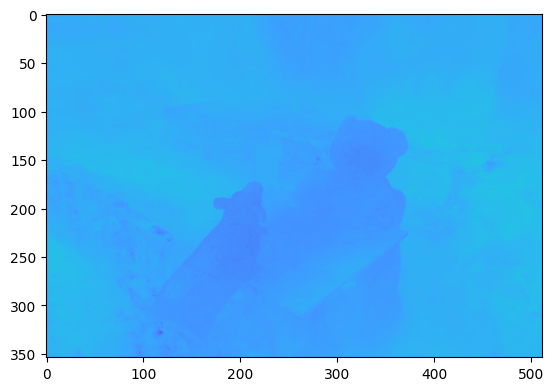

In [86]:
from torch.nn.functional import cosine_similarity

with torch.no_grad():
    tok_phrases = torch.cat([image_encoder.tokenizer(phrase) for phrase in positives]).to("cuda")
    pos_embeds = image_encoder.model.encode_text(tok_phrases)
    pos_embeds /= pos_embeds.norm(dim=-1, keepdim=True)

print(pos_embeds.shape)

cos_sim = cosine_similarity(feature_flatten, pos_embeds)
cos_sim = cos_sim.reshape(featuremap.shape[0], featuremap.shape[1], 1)
print(cos_sim.shape)
print(f'cos_sim min: {cos_sim.min()}, max: {cos_sim.max()}')

sim_heatmap = apply_colormap(cos_sim, ColormapOptions("turbo"))
mask = (cos_sim < 0.0).squeeze()
sim_heatmap[mask] = rgb_cuda[mask]

plt.imshow(sim_heatmap.cpu().numpy())

270 8


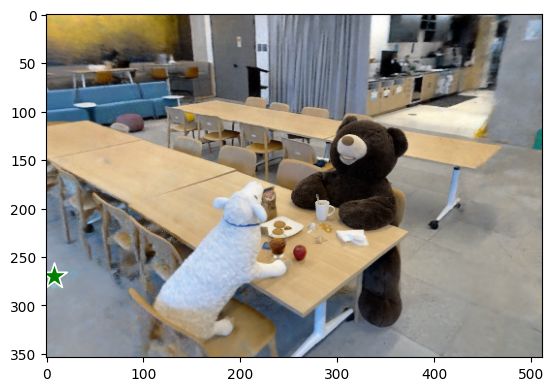

In [87]:
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)  

max_ind = torch.argmax(relevancy.reshape(-1, 1), dim=0).item()
h = max_ind // featuremap.shape[1]
w = max_ind % featuremap.shape[1]

# h = 200
# w = 140

print(h, w)

plt.imshow(rgb)
show_points(np.array([[w, h]]), np.array([1]), plt.gca())

pred_1 min: 0.3209930956363678, max: 1.0
pred_1 > fg_thres: 6203
1 - pred_1 > bg_thres: 35471
torch.Size([354, 512, 1])
self_support_mask min: 0.40677303075790405, max: 0.997194766998291
(354, 512)


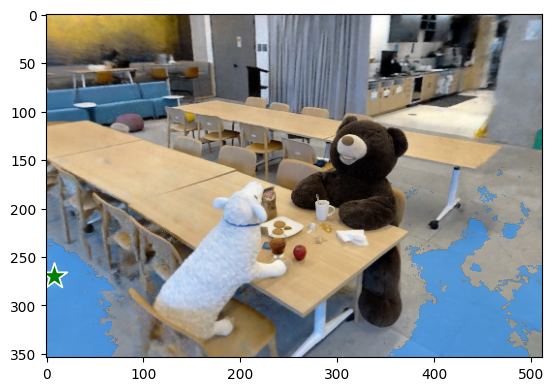

In [88]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

support_ray = feature_flatten[max_ind]
support_ray = support_ray.unsqueeze(0)

self_support_mask = self_support(feature_flatten, support_ray)
self_support_mask = self_support_mask.reshape(featuremap.shape[0], featuremap.shape[1], 1)
print(self_support_mask.shape)
print(f'self_support_mask min: {self_support_mask.min()}, max: {self_support_mask.max()}')

labels = (self_support_mask > 0.9).cpu().numpy().astype(np.int32)[..., 0]
print(labels.shape)

plt.imshow(rgb)
show_points(np.array([[w, h]]), np.array([1]), plt.gca())
show_mask(labels, plt.gca())

torch.Size([181248])
torch.Size([354, 512, 1])
sim max: 1.0, sim min: 0.3209930956363678


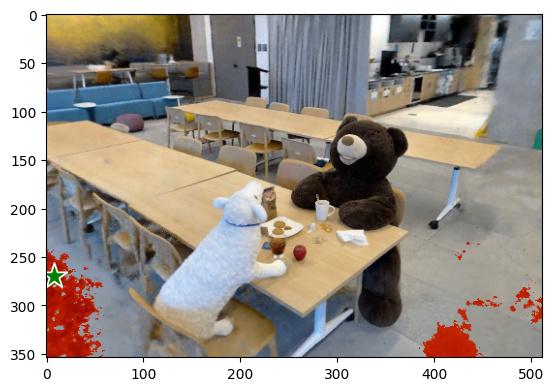

In [89]:
from torch.nn.functional import cosine_similarity

# support_sim = similar_func(feature_flatten, support_ray)
support_sim = cosine_similarity(feature_flatten, support_ray)

print(support_sim.shape)
support_sim = support_sim.reshape(featuremap.shape[0], featuremap.shape[1], 1)
print(support_sim.shape)
print(f'sim max: {support_sim.max()}, sim min: {support_sim.min()}')

sim_heatmap = apply_colormap(support_sim, ColormapOptions("turbo"))
mask = (support_sim < 0.9).squeeze()
sim_heatmap[mask] = rgb_cuda[mask]

plt.imshow(sim_heatmap.cpu().numpy())
show_points(np.array([[w, h]]), np.array([1]), plt.gca())

In [95]:
print(rgb_cuda.shape)
emb = image_encoder.encode_image(rgb_cuda.permute(2, 0, 1).unsqueeze(0))
print(emb.shape)

torch.Size([354, 512, 3])
torch.Size([1, 512])
